<div style="background-color:#5D73F2; color:#19180F; font-size:40px; font-family:Verdana; padding:10px; border: 5px solid #19180F; border-radius:10px"> XLM-RoBERTa </div>
<div style="background-color:#A8B4F6; color:#19180F; font-size:30px; font-family:Verdana; padding:10px; border: 5px solid #19180F; border-radius:10px"> Architecture Overview</div>
<div style="background-color:#D5D9F2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F; border-radius:10px"> 

1. The model's initial inputs are shown in the input section. Input Embedding and Language Embedding are its two constituent parts.<br><br>
- Input Embedding: This sub-component accepts input mask, segment IDs, and position IDs as well as input tokens. To turn these inputs into continuous vector representations, it performs embedding operations.<br><br>
- Language Embedding: By adding the language ID information to the appropriate embedding vectors, this sub-component incorporates the language ID information into the input embeddings.<br><br>
2. The transformer encoder, which is the main part of XLM-Roberta and is in charge of processing and transforming the input representations, is known as the transformer. It is made up of several stacked encoder layers, each of which has the following three sub-components: input embedding, self-attention, and feed-forward.<br><br>
- Input Embedding: Each encoder layer uses the output of the layer before it as its input embedding.<br><br>
- Self-Attention: The model can recognize contextual dependencies between various tokens in the input sequence thanks to the self-attention mechanism. For each token, it calculates attention weights, which are then combined with the corresponding token representations.<br><br>
- Feed-Forward: The feed-forward layer transforms the intermediate representations obtained from the self-attention layer in a non-linear manner.<br><br>
3. Output: The model's final stages are represented by the output section, where the analyzed data is converted into accurate forecasts or visual representations.<br><br>
- Pooling: The pooling component, which is typically mean pooling, combines all token representations into a single representation of a fixed size.<br><br>
- Classifier: The classifier part uses the pooled representation as input and applies a softmax function to produce predictions or carry out subsequent tasks, like text classification.<br><br>
The connections between the parts are denoted by arrows with labels that describe the operations or transformations happening. "Residual" labels are used to identify residual connections, which add the original input embeddings to a sub-component's output. The "Addition" labels show the element-by-element addition of various parts.
<br><br>
Overall, XLM-Roberta has the same architecture as the original Transformer model, with the addition of language embeddings and adjustments to efficiently handle multilingual tasks. It takes advantage of self-attention's ability to capture complex dependencies and stack encoders to produce high-quality representations for a range of natural language processing tasks.<br><br> </div>


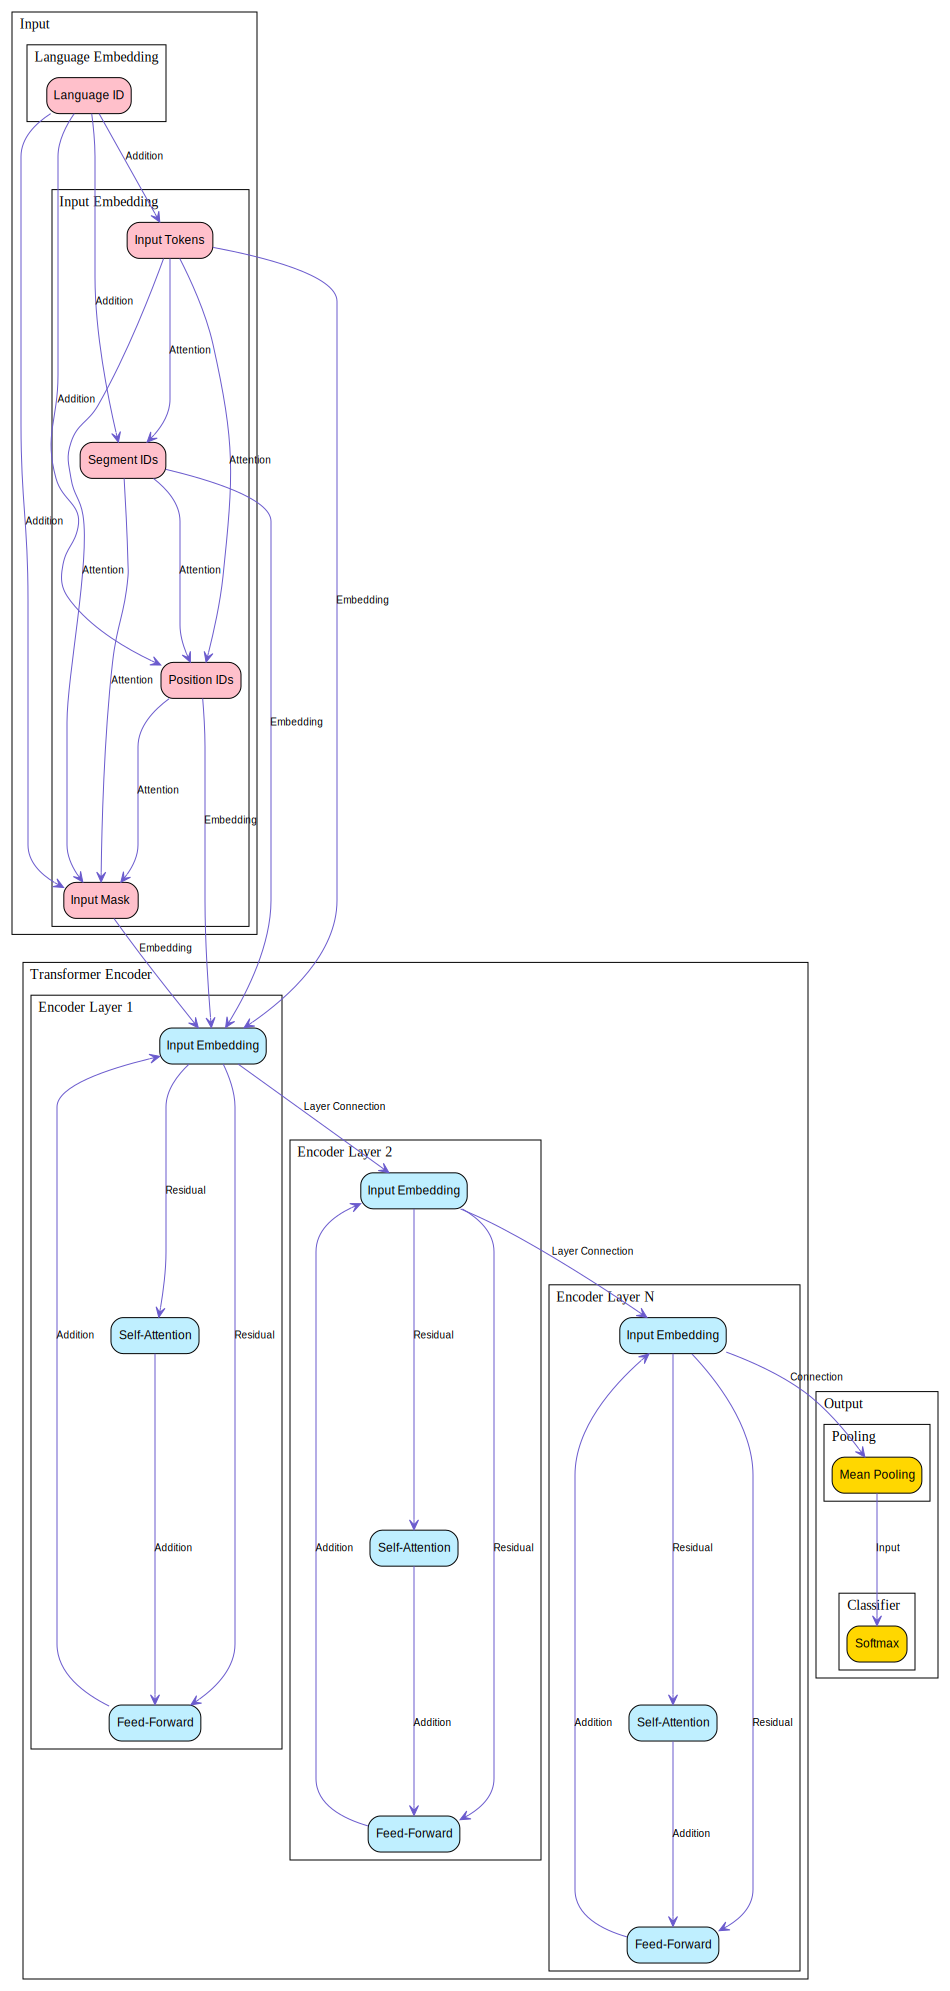

In [1]:
from IPython.display import SVG, display

# Load the SVG file and display it
svg_file = '/kaggle/input/xlm-roberta/xlm-roberta.svg'
display(SVG(filename=svg_file))

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
    Importing modules
    </div>

In [2]:
import torch
import pandas as pd
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from transformers import AdamW
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Reading the dataframes    </div>

In [3]:
train_df = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/train.csv')
test_df = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/train.csv')

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Inspecting the columns in the dataframes    </div>

In [4]:
train_df.columns

Index(['text_id', 'full_text', 'cohesion', 'syntax', 'vocabulary',
       'phraseology', 'grammar', 'conventions'],
      dtype='object')

In [5]:
test_df.columns

Index(['text_id', 'full_text', 'cohesion', 'syntax', 'vocabulary',
       'phraseology', 'grammar', 'conventions'],
      dtype='object')

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Creating dataset class for train and val splits    </div>

In [6]:
class EssayDataset(Dataset):
    def __init__(self, df, tokenizer, max_length, labels):
        self.texts = df['full_text'].tolist()
        self.labels = df[labels].values.tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label)
        }

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Defining tokenizer, max length and the labels    </div>

In [7]:
# #caching the tokenizer
# tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
# tokenizer.save_pretrained("/kaggle/working")

In [8]:
tokenizer = XLMRobertaTokenizer.from_pretrained('/kaggle/input/xlm-roberta')

In [9]:
max_length = 512 
labels = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Splitting the data into train, val splits followed by creating datasets and dataloaders    </div>

In [10]:
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42)
train_dataset = EssayDataset(train_data, tokenizer, max_length, labels)
val_dataset = EssayDataset(val_data, tokenizer, max_length, labels)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Performing sanity check of the dataloaders    </div>

In [11]:
for batch in train_dataloader:
    print(batch)
    break

{'input_ids': tensor([[     0,    262,    147,  ...,      1,      1,      1],
        [     0,   1401, 163846,  ...,    398,   3542,      2],
        [     0,  17915,    939,  ...,     10,   6183,      2],
        ...,
        [     0,  10660,    621,  ...,      1,      1,      1],
        [     0,  11853,     25,  ...,      1,      1,      1],
        [     0,     44,   4657,  ...,      1,      1,      1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([[3.5000, 4.0000, 4.0000, 3.5000, 3.5000, 4.0000],
        [2.5000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000],
        [4.0000, 3.0000, 4.0000, 3.5000, 3.5000, 3.0000],
        [3.0000, 2.5000, 3.0000, 3.0000, 3.0000, 2.5000],
        [3.0000, 2.5000, 2.5000, 2.0000, 2.0000, 2.5000],
        [3.5000, 3.0000, 3.5000, 2.5000, 3.0000, 3

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Instantiating models, moving it to the device and then the optimizer with learning rate    </div>

In [12]:
# #caching the model
# model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base', num_labels=len(labels))
# model.save_pretrained('/kaggle/working')


In [13]:
model = XLMRobertaForSequenceClassification.from_pretrained('/kaggle/input/xlm-roberta')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Checking the numbers of steps per epoch via length of the dataloaders    </div>

In [14]:
len(train_dataloader),len(val_dataloader)

(391, 98)

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Training and validation loop    </div>

In [15]:
import numpy as np

best_val_loss = float('inf')  # Initialize with a high value
best_model_path = '/kaggle/working/xlm-roberta-model.pth'

epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for step, batch in tqdm(enumerate(train_dataloader)):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        if step%100==0:
            print("Step-{},Train Loss-{}".format(step,loss.item()))

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)

    model.eval()
    val_loss = 0
    val_predictions = []
    val_labels = []
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1).tolist()
            val_predictions.extend(predictions)
            val_labels.extend(labels.tolist())

    avg_val_loss = val_loss / len(val_dataloader)

    # Perform evaluation or calculate evaluation metrics using val_predictions and val_labels

    print(f'Epoch {epoch + 1}/{epochs} - Training Loss: {avg_train_loss:.4f} - Validation Loss: {avg_val_loss:.4f}')

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
        print("Best model saved!")

# Load the best model
model.load_state_dict(torch.load(best_model_path))


0it [00:00, ?it/s]

Step-0,Train Loss-0.7605276107788086


100it [00:48,  2.14it/s]

Step-100,Train Loss--11.154098510742188


200it [01:35,  2.14it/s]

Step-200,Train Loss--14.306658744812012


300it [02:22,  2.13it/s]

Step-300,Train Loss--21.091934204101562


391it [03:04,  2.12it/s]


Epoch 1/5 - Training Loss: -15.2490 - Validation Loss: -24.5355
Best model saved!


0it [00:00, ?it/s]

Step-0,Train Loss--22.826507568359375


100it [00:46,  2.15it/s]

Step-100,Train Loss--26.378055572509766


200it [01:33,  2.14it/s]

Step-200,Train Loss--33.661285400390625


300it [02:20,  2.14it/s]

Step-300,Train Loss--33.82611846923828


391it [03:02,  2.14it/s]


Epoch 2/5 - Training Loss: -31.5040 - Validation Loss: -38.1382
Best model saved!


0it [00:00, ?it/s]

Step-0,Train Loss--39.82814025878906


100it [00:46,  2.15it/s]

Step-100,Train Loss--48.7097282409668


200it [01:33,  2.13it/s]

Step-200,Train Loss--44.52864074707031


300it [02:20,  2.15it/s]

Step-300,Train Loss--46.065914154052734


391it [03:02,  2.14it/s]


Epoch 3/5 - Training Loss: -44.7583 - Validation Loss: -51.0498
Best model saved!


0it [00:00, ?it/s]

Step-0,Train Loss--57.83164596557617


100it [00:46,  2.10it/s]

Step-100,Train Loss--52.46078109741211


200it [01:33,  2.14it/s]

Step-200,Train Loss--59.560638427734375


300it [02:20,  2.15it/s]

Step-300,Train Loss--62.40582275390625


391it [03:03,  2.14it/s]


Epoch 4/5 - Training Loss: -57.6389 - Validation Loss: -63.7595
Best model saved!


0it [00:00, ?it/s]

Step-0,Train Loss--62.54975128173828


100it [00:46,  2.13it/s]

Step-100,Train Loss--72.51144409179688


200it [01:33,  2.14it/s]

Step-200,Train Loss--81.20881652832031


300it [02:20,  2.14it/s]

Step-300,Train Loss--69.03150939941406


391it [03:02,  2.14it/s]


Epoch 5/5 - Training Loss: -70.3518 - Validation Loss: -76.3878
Best model saved!


<All keys matched successfully>

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Defining dataset class for test set by removing labels</div>

In [16]:
class TestSet(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.texts = df['full_text'].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
        }

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Creating dataset and dataloader for test set    </div>

In [17]:
test_dataset = TestSet(test_df, tokenizer, max_length)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Performing sanity check of the dataloader    </div>

In [18]:
for batch in test_dataloader:
    print(batch)
    break

{'input_ids': tensor([[     0,     87,   5351,  ...,      1,      1,      1],
        [     0,  14847,     10,  ...,   8966,   4488,      2],
        [     0,    262,    147,  ...,      1,      1,      1],
        ...,
        [     0,    262,    147,  ...,      1,      1,      1],
        [     0, 133196,   2174,  ...,      1,      1,      1],
        [     0,     87,   5351,  ...,      1,      1,      1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Generating submission    </div>

In [19]:
all_predictions = []

with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1).tolist()
        all_predictions.extend(predictions)

# Map the predictions to their respective scores
prediction_scores = [score / 2.0 + 1.0 for score in all_predictions]

submission_df = pd.DataFrame({
    'text_id': test_df['text_id'],
    'cohesion': prediction_scores,
    'syntax': prediction_scores,
    'vocabulary': prediction_scores,
    'phraseology': prediction_scores,
    'grammar': prediction_scores,
    'conventions': prediction_scores
})

submission_df.to_csv('submission.csv', index=False)


100%|██████████| 489/489 [01:20<00:00,  6.10it/s]
